# Reinforcement Learning: Two-armed Bandits

Bandits (aka slot machines) are some like of precursor of classic Reinforcement Learning problems. It is usually presented as a classic example of the Exploration/Exploitation dilemma. The dilemma is really simple, but deadly: the goal of the agent is to learn the optimal policy and behave optimally (**Exploitation** of the optimal policy); but how can the agent know that he ([1](no1)) is behaving optimally? How can he be so sure that he is not in a local maximum of the reward he it does not behave in non-optimal ways to find better actions (**Exploration** of the state-action spaces)?

Short answer: he can't.
Long answer: many workarounds are possible. In off-policy algorithms (where the behaviour policy b is in general different from the target policy $\pi$) exploration is usually not a problem. For on-policy algorithms (where we are using the policy that we are optimizing), a workaround could be using an $\epsilon$-greedy policy, to guarantee exploration to some extent.

<span href="no1"> (1) It is sometimes useful to think of agents in RL as blind people pushing buttons, receiving some kind of reward. How would you behave in such a situation? [This link](https://iosband.github.io/2015/07/28/Beat-the-bandit.html) provides a good example of how it could result simple until dimensionality does not kick in. </span>


In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

Bandits thresholds: [-1.4678054   0.00479167 -0.208263    0.00259766 -0.30573291 -0.19162611
  0.68459237 -0.21509677 -1.36324903 -0.26989063]


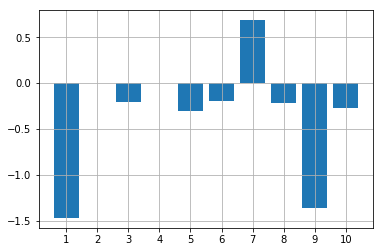

Best Bandit is 1 (lower is better)


In [2]:
# Bandits are actually just thresholds T. If a random number generator produces r > T, then it's a hit.
numBandits = 10
bandits = np.random.randn(numBandits)
print("Bandits thresholds: " + str(bandits))
plt.bar(np.arange(numBandits)+1, height=bandits)
plt.grid()
plt.xticks(np.arange(numBandits)+1)
plt.show()
print("Best Bandit is " + str(np.argmin(bandits)+1) + " (lower is better)")

def pullBandit(bandit):
    result = np.random.randn(1)
    if result > bandit:
        return 1
    else:
        return -1

### Bandits Algorithms
In this example, there is no State notion. All we can do is act on the environment and get a reward. This means that the notion of action-value function must not be related to both actions and states, but only on actions; moreover, since there is no state, there is terminal state. An episode is just acting once. 

Many algorithms are well-suited for bandits problems:
* **Simple bandit**: a is chosen $\epsilon$-greedily, and $Q(a)\leftarrow Q(a) + \frac{1}{N(a)}[R-Q(a)]$, where $N(a)$ keeps count of the number of times a is chosen.
* **Upper-Confidence-Bound Action Selection**: $a_t = \text{arg}\max_a [Q_t(a)+c\sqrt{\frac{\ln t}{N_t(a)}}]$, where t is the count of episodes and c is some constant, defining the degree of exploration. Exploration is not anymore guaranteed by the $\epsilon$-greedy action choice, but following the potential of each action for being optimal, taking into account how close their estimates are to being maximal and the uncertainties in those estimates.
* **Gradient Bandit**: learn a numerical _preference_ $H_t(a)$, then used to compute $$\pi_t(a) = \frac{e^{H_t(a)}}{\sum_{b=1}^k e^{H_t(b)}}$$ which is a softmax distribution. 

In [3]:
# Simple Bandit
Q = np.zeros([numBandits])
N = np.zeros([numBandits])
e = 0.1

numEpisodes = 1000
update = 50
totalReward = np.zeros([numBandits])
plotReward_simple = []
meanReward_simple = []

print("Simple Bandit Algorithm\n---------------------------------------------------------------------")

for i in range(numEpisodes):
    if np.random.rand(1) < e:
        action = np.random.randint(numBandits)
    else:
        action = np.argmax(Q)
    reward = pullBandit(bandits[action])
    N[action] += 1
    Q[action] += 1./N[action] *(reward - Q[action])
    totalReward[action] += reward
    
    plotReward_simple.append(np.sum(totalReward))
    meanReward_simple.append(plotReward_simple[i]/(i+1))
    if i % update == 0:
        print("Cumulative reward for each bandit: " + str(totalReward))
            
print("The agent thinks bandit " + str(np.argmax(Q)+1) + " is the most promising....")
if np.argmax(Q) == np.argmin(np.array(bandits)):
    print("...and it was right!")
else:
    print("...and it was wrong!")

#plt.plot(plot_reward_simple)
#plt.plot(range(total_episodes), plot_reward, 'r', range(total_episodes), mean_reward, 'b')

Simple Bandit Algorithm
---------------------------------------------------------------------
Cumulative reward for each bandit: [1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
Cumulative reward for each bandit: [33.  0.  0.  0.  0.  0.  0.  0.  8.  2.]
Cumulative reward for each bandit: [70.  0.  0. -2.  0.  0.  0. -1.  9.  1.]
Cumulative reward for each bandit: [111.   0.   0.  -2.   0.   0.  -1.  -1.   9.   1.]
Cumulative reward for each bandit: [153.   0.   0.  -1.   0.   1.  -2.  -1.   9.   2.]
Cumulative reward for each bandit: [198.   0.   0.  -1.   0.   0.  -2.  -1.   9.   2.]
Cumulative reward for each bandit: [241.  -1.   0.  -1.   0.   0.  -2.  -2.   9.   3.]
Cumulative reward for each bandit: [281.  -1.   1.  -1.   1.   0.  -2.  -1.   9.   4.]
Cumulative reward for each bandit: [325.  -1.   3.  -1.   1.   0.  -2.  -2.  10.   4.]
Cumulative reward for each bandit: [365.  -1.   3.  -1.   1.  -1.  -2.  -3.  10.   4.]
Cumulative reward for each bandit: [410.  -1.   3.  -2.   2.  -1.  -2.  -2. 

In [4]:
# Upper-Confidence-Bound (UCB) action selection
Q = np.zeros([numBandits])
N = np.zeros([numBandits])
c = 0.1

# numEpisodes = 1000
totalReward = np.zeros([numBandits])
plotReward_UCB = []
meanReward_UCB = []

print("Upper Confidence Bound Algorithm\n---------------------------------------------------------")

for i in range(numEpisodes):
    action = np.argmax(Q + c*np.sqrt(np.log(i+1)/(N+0.1)))
    reward = pullBandit(bandits[action])
    N[action] += 1
    Q[action] += 1./N[action] *(reward - Q[action])
    totalReward[action] += reward
    plotReward_UCB.append(np.sum(totalReward))
    meanReward_UCB.append(plotReward_UCB[i]/(i+1))
    if i % update == 0:
        print("Cumulative reward for each bandit: " + str(totalReward))
            
print("The agent thinks bandit " + str(np.argmax(Q)+1) + " is the most promising....")
if np.argmax(Q) == np.argmin(np.array(bandits)):
    print("...and it was right!")
else:
    print("...and it was wrong!")

#plt.plot(plot_reward)

Upper Confidence Bound Algorithm
---------------------------------------------------------
Cumulative reward for each bandit: [1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
Cumulative reward for each bandit: [47.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
Cumulative reward for each bandit: [89.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
Cumulative reward for each bandit: [131.   0.   0.   0.   0.   0.   0.   0.   0.   0.]
Cumulative reward for each bandit: [177.   0.   0.   0.   0.   0.   0.   0.   0.   0.]
Cumulative reward for each bandit: [221.   0.   0.   0.   0.   0.   0.   0.   0.   0.]
Cumulative reward for each bandit: [269.   0.   0.   0.   0.   0.   0.   0.   0.   0.]
Cumulative reward for each bandit: [309.   0.   0.   0.   0.   0.   0.   0.   0.   0.]
Cumulative reward for each bandit: [357.   0.   0.   0.   0.   0.   0.   0.   0.   0.]
Cumulative reward for each bandit: [407.   0.   0.   0.   0.   0.   0.   0.   0.   0.]
Cumulative reward for each bandit: [449.   0.   0.   0.   0.   0.   0.   0.   0

In [5]:
# Gradient Bandit
H = np.zeros([numBandits])
lr = 0.9
pi = 1./numBandits * np.ones(numBandits)

# numEpisodes = 1000
totalReward = np.zeros([numBandits])
plotReward_Grad = []
meanReward_Grad = []

print("Gradient Bandit Algorithm\n----------------------------------------------")

for i in range(numEpisodes):

    action = np.random.choice(numBandits, 1, p=pi)
    reward = pullBandit(bandits[action])
    
    totalReward[action] += reward
    plotReward_Grad.append(np.sum(totalReward))
    meanReward_Grad.append(plotReward_Grad[i]/(i+1))
    
    for a in range(numBandits):
        if a == action:
            H[a] = H[a] + lr*(reward - meanReward_Grad[i])*(1-pi[a])
        else:
            H[a] = H[a] - lr*(reward - meanReward_Grad[i])*pi[a]
        pi[a] = np.exp(H[a])/np.sum(np.exp(H))
    # Normalization to avoid numerical problems
    pi = pi/np.sum(pi)
                              
    if i % update == 0:
        print("Cumulative reward for each bandit: " + str(totalReward))
            
print("The agent thinks bandit " + str(np.argmax(pi)+1) + " is the most promising....")
if np.argmax(pi) == np.argmin(np.array(bandits)):
    print("...and it was right!")
else:
    print("...and it was wrong!")

# plt.plot(plot_reward)

Gradient Bandit Algorithm
----------------------------------------------
Cumulative reward for each bandit: [0. 0. 0. 0. 0. 1. 0. 0. 0. 0.]
Cumulative reward for each bandit: [17.  0.  0.  1. -1.  1. -2.  1.  3.  1.]
Cumulative reward for each bandit: [59.  0.  2.  1. -1.  1. -2.  1.  3.  1.]
Cumulative reward for each bandit: [105.   0.   2.   1.  -1.   1.  -2.   1.   3.   1.]
Cumulative reward for each bandit: [144.   0.   1.   1.  -1.   1.  -2.   1.   3.   1.]
Cumulative reward for each bandit: [184.   0.   1.   1.  -1.   1.  -2.   1.   3.   1.]
Cumulative reward for each bandit: [226.   0.   1.   1.  -1.   1.  -2.   1.   3.   1.]
Cumulative reward for each bandit: [266.   0.   1.   1.  -1.   1.  -2.   1.   3.   1.]
Cumulative reward for each bandit: [306.   0.   1.   1.  -1.   1.  -2.   1.   3.   1.]
Cumulative reward for each bandit: [346.   0.   1.   1.  -1.   1.  -2.   1.   3.   1.]
Cumulative reward for each bandit: [386.   0.   1.   1.  -1.   1.  -2.   1.   3.   1.]
Cumulative

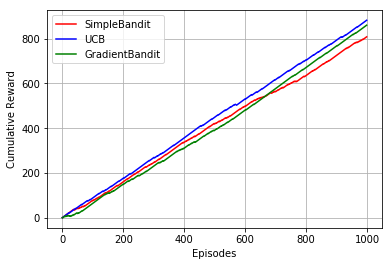

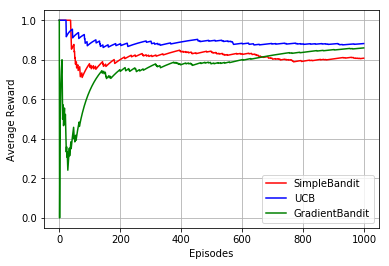

In [6]:
# Plot Cumulative and Average Reward
plt.plot(range(numEpisodes), plotReward_simple, color='r', label='SimpleBandit')
plt.plot(range(numEpisodes), plotReward_UCB, color='b', label='UCB')
plt.plot(range(numEpisodes), plotReward_Grad, color='g', label='GradientBandit')
plt.legend()
plt.grid()
plt.xlabel('Episodes')
plt.ylabel('Cumulative Reward')
plt.show()

plt.plot(range(numEpisodes), meanReward_simple, color='r', label='SimpleBandit')
plt.plot(range(numEpisodes), meanReward_UCB, color='b', label='UCB')
plt.plot(range(numEpisodes), meanReward_Grad, color='g', label='GradientBandit')
plt.legend()
plt.grid()
plt.xlabel('Episodes')
plt.ylabel('Average Reward')
plt.show()


### Weight learning
The problem can also be solved with a neural network: in this case a super simple net is used, that is just a vector of weights, each one associated with a bandit. The highest weight is the one that is responsible for action selection.

The loss is just the log-likelihood loss over the chosen action: this means that the gradient is computed only over one weight.

In [7]:
# Define simple network: one layer perceptron
tf.reset_default_graph()
weights = tf.Variable(tf.ones([numBandits]))
chosenAction = tf.argmax(weights, 0)

rewardHolder = tf.placeholder(shape=[1], dtype=tf.float32)
actionHolder = tf.placeholder(shape=[1], dtype=tf.int32)
responsibleWeight = tf.slice(weights, actionHolder, [1])
loss = -tf.log(responsibleWeight)*rewardHolder
optimizer = tf.train.GradientDescentOptimizer(learning_rate=0.001)
updateNet = optimizer.minimize(loss)

In [8]:
numEpisodes_net = numEpisodes
totalReward = np.zeros(numBandits)
plotReward_net = []
meanReward_net = []
e = 0.1

init = tf.global_variables_initializer()

with tf.Session() as sess:
    sess.run(init)
    i = 0
    while i < numEpisodes_net:
        if np.random.rand(1) < e:
            action = np.random.randint(numBandits)
        else:
            action = sess.run(chosenAction)
            
        reward = pullBandit(bandits[action])
        
        _, resp, ww = sess.run([updateNet, responsibleWeight, weights], \
                               feed_dict={rewardHolder:[reward], actionHolder:[action]})
        totalReward[action] += reward
        plotReward_net.append(np.sum(totalReward))
        meanReward_net.append(np.sum(totalReward)/(i+1))
        if i % update == 0:
            print("Cumulative reward for each bandit: " + str(totalReward))
        i+=1
print("The agent thinks bandit " + str(np.argmax(ww)+1) + " is the most promising....")
if np.argmax(ww) == np.argmin(np.array(bandits)):
    print("...and it was right!")
else:
    print("...and it was wrong!")
    
# plt.plot(plotReward_net)

Cumulative reward for each bandit: [1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
Cumulative reward for each bandit: [33.  0.  1.  0. -1.  0. -1.  0.  0.  1.]
Cumulative reward for each bandit: [73.  0.  1.  0. -1.  0. -1.  0.  2.  1.]
Cumulative reward for each bandit: [108.   0.   0.   0.  -1.  -1.  -1.   2.   2.   0.]
Cumulative reward for each bandit: [149.   0.   0.   0.  -1.   0.  -1.   3.   2.  -1.]
Cumulative reward for each bandit: [186.   2.   1.   0.  -1.   0.   0.   2.   3.  -2.]
Cumulative reward for each bandit: [223.   2.   1.   0.  -1.   1.  -2.   2.   3.  -2.]
Cumulative reward for each bandit: [266.   2.   1.   0.   0.   1.  -2.   2.   5.  -2.]
Cumulative reward for each bandit: [304.  -2.   1.  -1.   0.   2.  -2.   2.   5.  -2.]
Cumulative reward for each bandit: [341.  -3.   2.   0.   0.   2.  -2.   2.   5.  -2.]
Cumulative reward for each bandit: [377.  -2.   2.  -1.   0.   2.  -3.   0.   7.  -3.]
Cumulative reward for each bandit: [419.  -3.   1.   0.   0.   2.  -3.   0.   8.  -

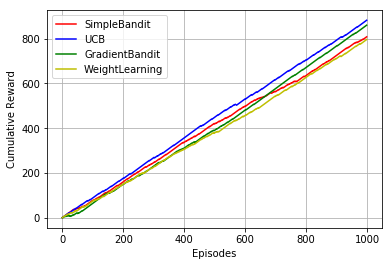

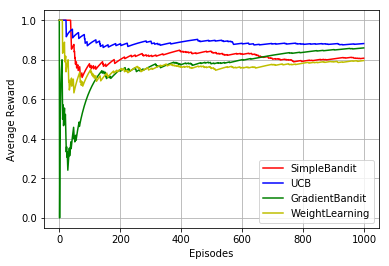

In [9]:
# Plot Cumulative and Average Reward
plt.plot(range(numEpisodes), plotReward_simple, color='r', label='SimpleBandit')
plt.plot(range(numEpisodes), plotReward_UCB, color='b', label='UCB')
plt.plot(range(numEpisodes), plotReward_Grad, color='g', label='GradientBandit')
plt.plot(range(numEpisodes), plotReward_net, color='y', label='WeightLearning')
plt.legend()
plt.grid()
plt.xlabel('Episodes')
plt.ylabel('Cumulative Reward')
plt.show()

plt.plot(range(numEpisodes), meanReward_simple, color='r', label='SimpleBandit')
plt.plot(range(numEpisodes), meanReward_UCB, color='b', label='UCB')
plt.plot(range(numEpisodes), meanReward_Grad, color='g', label='GradientBandit')
plt.plot(range(numEpisodes), meanReward_net, color='y', label='WeightLearning')
plt.legend()
plt.grid()
plt.xlabel('Episodes')
plt.ylabel('Average Reward')
plt.show()

Different Bandit Algorithms are suitable for different situations, but in general the more the agent explores (and uses sub-optimal policy), the more likely it is that it finds the optimal solution. At the same time, exploring leads to higher regret. 

For each algorithm at least one "hyperparameter" is tunable. Sometimes a proper tuning improves radically the outcome of the algorithm.